In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large, EfficientNetV2S 
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
import matplotlib.pyplot as plt  
import numpy as np 

In [5]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32

#Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cell_images",              
    validation_split=0.2,       
    subset="training",          
    seed=123,                  
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,              
    label_mode='binary',       
    interpolation='bilinear'   
)

#Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cell_images",
    validation_split=0.2,
    subset="validation",       
    seed=123,                
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,          
    label_mode='binary',
    interpolation='bilinear'
)


Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [6]:
count_parasitized = 0
count_uninfected = 0

for images, labels in val_ds.unbatch():
    if labels.numpy() == 0:
        count_parasitized += 1
    else:
        count_uninfected += 1

print(f"Parasitized: {count_parasitized}, Uninfected: {count_uninfected}")


Parasitized: 2709, Uninfected: 2802


In [7]:
for images, labels in val_ds.unbatch().take(10):
    print(labels.numpy())

[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]


In [8]:
base_model = MobileNetV3Small(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')
base_model.trainable = False  

model = models.Sequential([
    base_model, 
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [9]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 381s 542ms/step - accuracy: 0.9254 - loss: 0.1967 - val_accuracy: 0.9561 - val_loss: 0.1246
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 446ms/step - accuracy: 0.9570 - loss: 0.1306 - val_accuracy: 0.9548 - val_loss: 0.1312
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 289s 420ms/step - accuracy: 0.9585 - loss: 0.1224 - val_accuracy: 0.9528 - val_loss: 0.1400
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 285s 414ms/step - accuracy: 0.9591 - loss: 0.1168 - val_accuracy: 0.9581 - val_loss: 0.1213
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 354s 461ms/step - accuracy: 0.9605 - loss: 0.1123 - val_accuracy: 0.9614 - val_loss: 0.1140
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 331s 479ms/step - accuracy: 0.9632 - loss: 0.1075 - val_accuracy: 0.9595 - val_loss: 0.1126
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 318s 461ms/step - accuracy: 0.9620 - loss: 0.1036 - val_accuracy: 0.9606 - val_loss: 0.1108
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 328s 475ms/step - accuracy: 0.9647 -

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2709
  Uninfected       0.95      0.97      0.96      2802

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511



<Figure size 600x600 with 0 Axes>

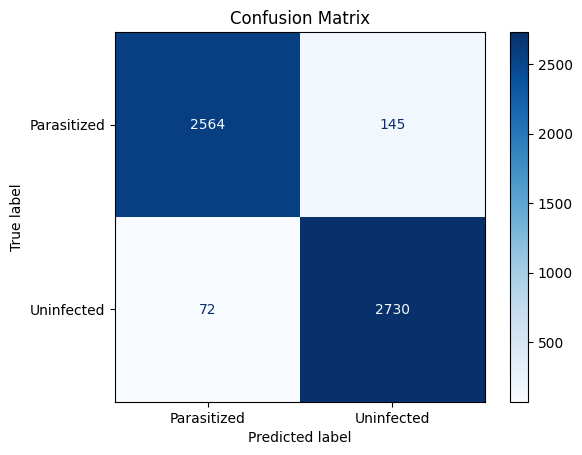

In [10]:
# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int).flatten()  
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Parasitized", "Uninfected"])

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [11]:
model.save('malaria_mobilenetSmall.keras')

In [12]:
import tensorflow as tf
import numpy as np
from safetensors.numpy import save_file

# Load the Keras model
model = tf.keras.models.load_model("malaria_mobilenetSmall.keras")

# Get ALL weights (trainable + non-trainable)
weight_dict = {}
for layer in model.layers:
    for i, weight in enumerate(layer.weights):
        # Preserve original naming format
        name = f"{layer.name}_{i}"
        weight_dict[name] = weight.numpy()

# Save with proper metadata
metadata = {
    "framework": "keras",
    "model_type": "MobileNetV3",
    "task": "malaria_detection"
}
save_file(weight_dict, "malaria_mobilenetSmall.safetensors", metadata=metadata)

# ✅ Corrected print statement
total_params = sum(np.prod(v.shape) for v in weight_dict.values())
print(f"✅ Saved {len(weight_dict)} tensors ({total_params:,} total parameters)")


✅ Saved 210 tensors (1,013,105 total parameters)


In [ ]:
import json 

config = {
    "model_type": "MobileNetV3Large",
    "input_shape": [1, 224, 224, 3],
    "num_classes": 1,
    "activation": "sigmoid",
    "pooling": "global_average",
    "hidden_units": [128],
    "framework": "keras",
    "pretrained_base": "imagenet",
    "trainable_base": False,
    "classifier_head": {
        "dense_1": {
            "units": 128,
            "activation": "relu"
        },
        "output": {
            "units": 1,
            "activation": "sigmoid"
        }
    }
}

with open("configLarge.json", "w") as f:
    json.dump(config, f, indent=2)


In [ ]:
with open("configLarge.json") as f:
    config = json.load(f)

# Build MobileNetV3Large base model
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=tuple(config["input_shape"][1:]),  # [224,224,3]
    include_top=False,
    weights=config["pretrained_base"] if config["pretrained_base"] != "none" else None,
    pooling=config["pooling"]
)

base_model.trainable = config["trainable_base"]

# Build classifier head
inputs = tf.keras.Input(shape=tuple(config["input_shape"][1:]))
x = base_model(inputs, training=False)
for units in config["hidden_units"]:
    x = tf.keras.layers.Dense(units, activation='relu')(x)
outputs = tf.keras.layers.Dense(
    config["classifier_head"]["output"]["units"],
    activation=config["classifier_head"]["output"]["activation"]
)(x)

model = tf.keras.Model(inputs, outputs)

# Save the model before quantizing
model.save('mobilenet_model.keras')


In [ ]:
# Load the saved model
model = tf.keras.models.load_model('mobilenet_model.keras')

# Create TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define representative dataset for calibration
def representative_dataset():
    for _ in range(100):
        # You should replace this with your actual preprocessing pipeline
        data = tf.random.uniform([1, 224, 224, 3], minval=0, maxval=255, dtype=tf.float32)
        yield [data]

converter.representative_dataset = representative_dataset

# Force INT8 ops for both input and output
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert and save
tflite_model = converter.convert()
with open('mobilenet_v3_large_int8.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp9x3i0e23\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp9x3i0e23\assets


Saved artifact at 'C:\Users\PC\AppData\Local\Temp\tmp9x3i0e23'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 7, 7, 1), dtype=tf.float32, name=None)
Captures:
  1979629139072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629165856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629167440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629161280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629162160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629174128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629209024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629211488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629171840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1979629207968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

d:\MalariaModel\malaria-310\lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
